# Herron Topic 4 - Practice (Monday 2:45 PM, Section 3)

## Announcements

- Quiz 6 this week
    - I will post it at about 6 PM on Wednesday, 3/31
    - It will be due by 11:59 PM on Friday, 3/31
- Please complete the week ten survey
    - I am considering dropping a topic to allow more in-class group work and easier access to me
    - I am also curious why the quantitative courses are less popular this summer
    - Please complete by 11:59 PM on Friday, 3/31
    - ***The week ten survey is anonymous and voluntary***
- I will post project 2 as soon as I can
- Assessment exam
    - 20 questions multiple on Canvas
    - ***You must be in the class room***
    - No specific studying, but I suggest putting core course resources on your laptop (e.g., notes and PowerPoints)

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [4]:
import scipy.optimize as sco

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years

***Note that `sco.minimize()` finds minimums, so we need to minimize the negative Sharpe Ratio.***

The following code downloads data for the MATANA stocks and assigns daily decimal returns from 2020 through 2022 to data frame `returns`.
We will stop in 2022 to make it easier to compare our results, whether we use the risk-free rate or value-weighted market portfolio as our benchmark or not.
Recall, the Fama and French benchmark factors are only available with a lag, and are only available through December 2022 as I type.

In [5]:
tickers = 'MSFT AAPL TSLA AMZN NVDA GOOG'

matana = (
    yf.download(tickers=tickers, progress=False)
    .assign(Date=lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)

returns = matana['Adj Close'].pct_change().loc['2020':'2022']
returns.describe()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
count,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000
mean,0.0011,0.0002,0.0006,0.0008,0.0018,0.0030
std,0.0233,0.0246,0.0217,0.0219,0.0352,0.0455
min,-0.1286,-0.1405,-0.1110,-0.1474,-0.1845,-0.2106
25%,-0.0110,-0.0129,-0.0097,-0.0097,-0.0177,-0.0215
50%,0.0006,0.0006,0.0012,0.0007,0.0029,0.0020
75%,0.0142,0.0123,0.0114,0.0123,0.0222,0.0251
max,0.1198,0.1354,0.0940,0.1422,0.1716,0.1989


In [6]:
def port_sharpe(x, r, ppy, tgt):
    """
    x: portfolio weights
    r: data frame of returns
    ppy: periods per year for annualization
    tgt: target or benchmark
    """
    rp = r.dot(x) # portfolio return
    er = rp.sub(tgt).dropna() # portfolio excess return
    return np.sqrt(ppy) * er.mean() / er.std() # portfolio Sharpe Ratio

In [7]:
def port_sharpe_neg(x, r, ppy, tgt):
    return -1 * port_sharpe(x, r, ppy, tgt)

In [8]:
res_sharpe_1 = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 252, 0),
    bounds=[(0,1) for _ in range(returns.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # want eq constraint to = 0
    )
)

res_sharpe_1

     fun: -1.0891990698266503
     jac: array([ 1.1642e-04,  3.6243e-01,  1.1961e-01,  6.4995e-02,  4.9071e-04,
       -2.5976e-04])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([6.6102e-02, 8.1640e-17, 7.1991e-17, 0.0000e+00, 3.1307e-01,
       6.2083e-01])

In [9]:
port_sharpe(x=res_sharpe_1['x'], r=returns, ppy=252, tgt=0)

1.0891990698266503

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but allow short weights up to 10% on each stock

In [10]:
res_sharpe_2 = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 252, 0),
    bounds=[(-.1,1.5) for _ in range(returns.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # want eq constraint to = 0
    )
)

res_sharpe_2

     fun: -1.1368990608896157
     jac: array([0.041 , 0.3444, 0.1157, 0.0727, 0.041 , 0.041 ])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.2997, -0.1   , -0.1   , -0.1   ,  0.3745,  0.6258])

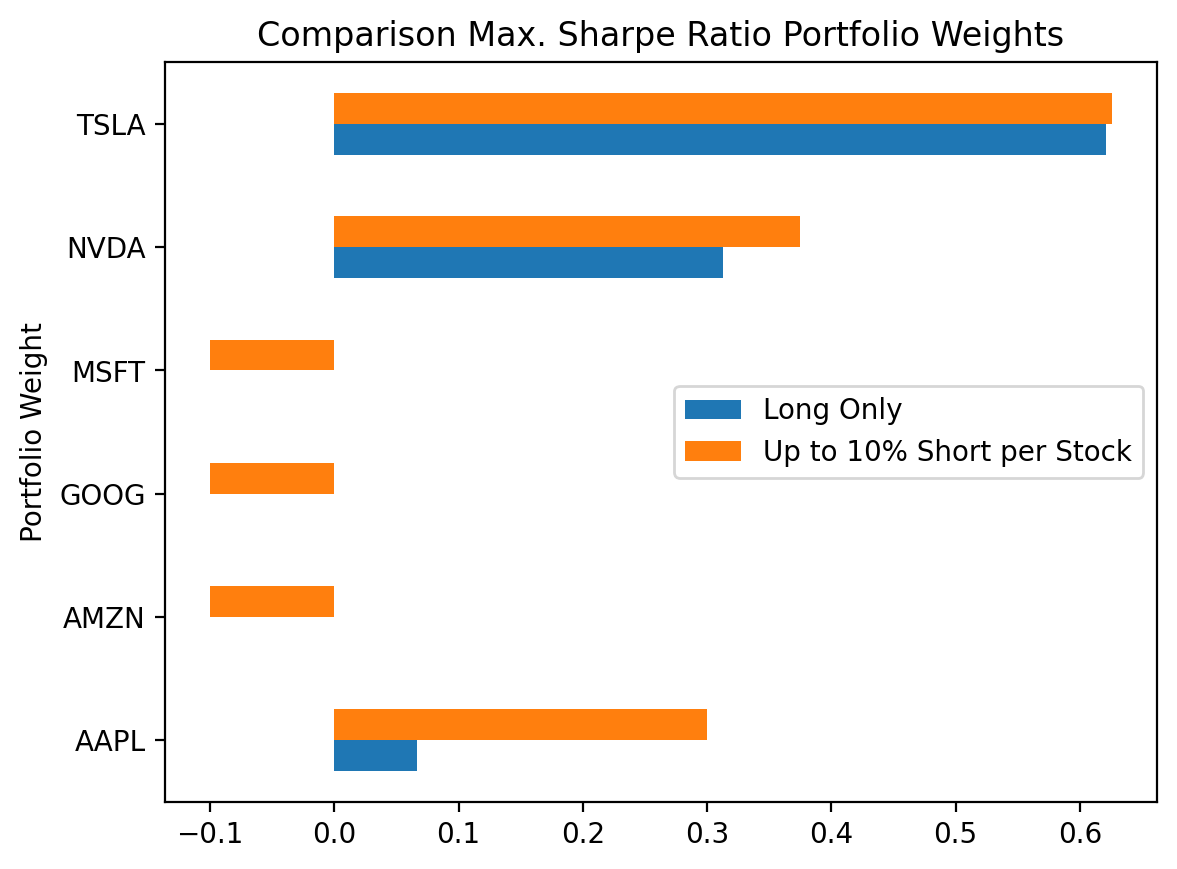

In [11]:
(
    pd.DataFrame(
        data={
            'Long Only':res_sharpe_1['x'], 
            'Up to 10% Short per Stock':res_sharpe_2['x']
        },
        index=returns.columns
    )
    .rename_axis('Portfolio Weight')
    .plot(kind='barh')
)
plt.title('Comparison Max. Sharpe Ratio Portfolio Weights')
plt.show()

By relaxing the long-only constrain (via changes to `bounds=`), the weights on AMZN, GOOG, and MSFT go from zero to -10%.
Also, the Sharpe Ratio increases because we relax a binding constraint.

In [12]:
port_sharpe(res_sharpe_1['x'], r=returns, ppy=252, tgt=0)

1.0891990698266503

In [13]:
port_sharpe(res_sharpe_2['x'], r=returns, ppy=252, tgt=0)

1.1368990608896157

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but allow total short weights of up to 30%

We can find the negative values in a NumPy array as follows.

In [14]:
x = np.arange(10) - 5
x_neg = x[x < 0]
print(f'All Values: {x}\nNegative Values: {x_neg}')

All Values: [-5 -4 -3 -2 -1  0  1  2  3  4]
Negative Values: [-5 -4 -3 -2 -1]


In [15]:
res_sharpe_3 = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 252, 0),
    bounds=[(-0.3,1.3) for _ in range(returns.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # want eq constraint to = 0
        {'type': 'ineq', 'fun': lambda x: x[x < 0].sum() + 0.3} # want ineq constraint to >= 0
    )
)

res_sharpe_3

     fun: -1.1826812160909803
     jac: array([0.0782, 0.336 , 0.1519, 0.1096, 0.0773, 0.0773])
 message: 'Optimization terminated successfully'
    nfev: 100
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 3.5659e-01, -3.0000e-01, -7.2559e-10,  1.7959e-05,  3.4963e-01,
        5.9376e-01])

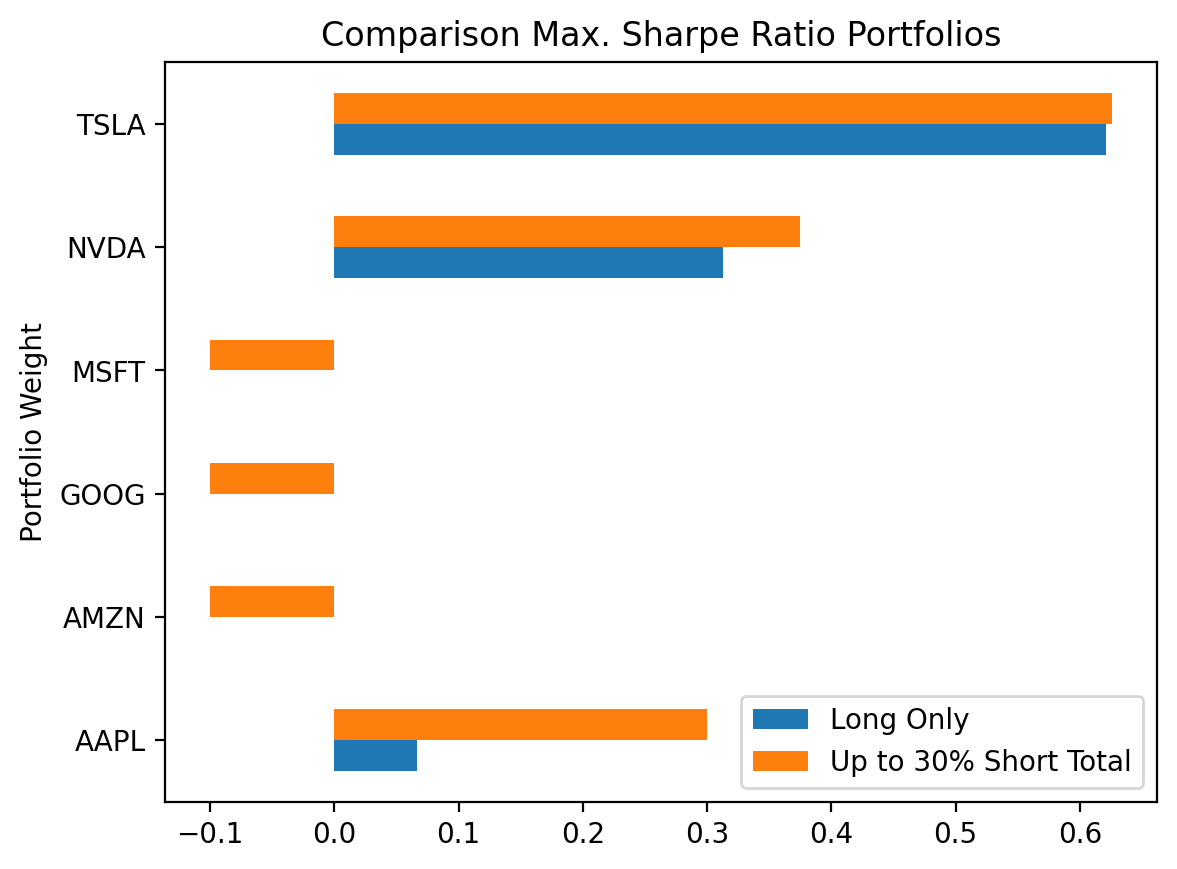

In [16]:
(
    pd.DataFrame(
        data={
            'Long Only':res_sharpe_1['x'], 
            'Up to 30% Short Total':res_sharpe_2['x']
        },
        index=returns.columns
    )
    .rename_axis('Portfolio Weight')
    .plot(kind='barh')
)
plt.title('Comparison Max. Sharpe Ratio Portfolios')
plt.show()

Again, by relaxing the long-only constrain, the weights on AMZN, GOOG, and MSFT go from zero to -10%.
Also, the Sharpe Ratio increases because we relax a binding constraints.
The Sharpe Ratio is higher here than in the previous exercise, but this will not always be the case, since we relax different constraints here and in the previous exercise.

In [17]:
port_sharpe(res_sharpe_1['x'], r=returns, ppy=252, tgt=0)

1.0891990698266503

In [18]:
port_sharpe(res_sharpe_3['x'], r=returns, ppy=252, tgt=0)

1.1826812160909803

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but do not allow any weight to exceed 30% in magnitude

We can do this easily with `bounds=`.

In [19]:
res_sharpe_4 = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 252, 0),
    tol=1e-6,
    bounds=[(0,0.3) for _ in range(returns.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # want eq constraint to = 0
    )
)

res_sharpe_4

     fun: -1.0342974862116496
     jac: array([ 0.1105,  0.5249,  0.2314,  0.176 ,  0.0964, -0.2655])
 message: 'Optimization terminated successfully'
    nfev: 21
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([3.0000e-01, 0.0000e+00, 1.0408e-17, 1.0000e-01, 3.0000e-01,
       3.0000e-01])

***I removed the version that achieved the same result with constraints, because it did not work the same on different computers.***
I cannot find documentation for why this solution fails, but I suspect using the `.max()` method in a constraint makes convergence slower because changes to non-max values in `x` do not change the constraint function output.

### Find the minimum 95% Value at Risk (Var) portfolio of MATANA stocks over the last three years

More on VaR [here](https://en.wikipedia.org/wiki/Value_at_risk).

In [20]:
def port_var(x, r, q):
    return r.dot(x).quantile(q)

In [21]:
def port_var_neg(x, r, q):
    return -1 * port_var(x=x, r=r, q=q)

In [22]:
res_var_1 = sco.minimize(
    fun=port_var_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 0.05),
    bounds=[(0,1) for _ in returns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_var_1

     fun: 0.03592250509338485
     jac: array([0.0359, 0.0419, 0.037 , 0.0385, 0.0275, 0.0416])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.8180e-01, 1.4369e-01, 2.2517e-01, 2.4347e-01, 2.0587e-01,
       2.6479e-17])

In [23]:
port_var(x=res_var_1['x'], r=returns, q=0.05)

-0.03592250509338485

It might be helpful to slightly change then minimum VaR portfolio weights to show that we minimized VaR.

In [24]:
def tweak(x, d=0.05):
    y = np.zeros(x.shape[0])
    y[0], y[1] = d, -1 * d
    return x + y

In [25]:
port_var(x=tweak(res_var_1['x']), r=returns, q=0.05)

-0.03622949371096426

### Find the minimum maximum draw down portfolio of MATANA stocks over the last three years

In [26]:
def port_draw_down_max(x, r):
    rp = r.dot(x)
    price = rp.add(1).cumprod()
    cum_max = price.cummax()
    draw_down = (cum_max - price) / cum_max
    return draw_down.max()

In [27]:
res_dd_1 = sco.minimize(
    fun=port_draw_down_max,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns,),
    bounds=[(0,1) for _ in returns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_dd_1

     fun: 0.2973739393829374
     jac: array([0.2865, 0.5131, 0.4028, 0.2927, 0.5359, 0.7698])
 message: 'Optimization terminated successfully'
    nfev: 164
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([6.8105e-01, 5.4865e-16, 2.2106e-15, 3.1895e-01, 4.8634e-16,
       5.7586e-16])

In [28]:
port_draw_down_max(x=res_dd_1['x'], r=returns)

0.2974

Again. it might be helpful to slightly change then minimum VaR portfolio weights to show that we minimized VaR.

In [29]:
port_draw_down_max(x=tweak(res_dd_1['x']), r=returns)

0.3065

### Find the minimum maximum draw down portfolio with all available data for the current Dow-Jones Industrial Average (DJIA) stocks

You can find the [DJIA tickers on Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).

In [30]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')

In [31]:
djia = (
    yf.download(tickers=wiki[1]['Symbol'].to_list(), progress=False)
    .assign(Date=lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)

returns_2 = djia['Adj Close'].pct_change().loc[:'2022'].dropna()
returns_2.describe()

Ticker,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
count,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,...,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000,954.0000
mean,0.0013,0.0006,0.0007,-0.0001,0.0009,0.0001,0.0002,0.0009,0.0000,0.0006,...,0.0006,0.0010,0.0006,0.0006,0.0007,0.0010,0.0005,-0.0001,-0.0001,0.0006
std,0.0218,0.0167,0.0259,0.0350,0.0211,0.0258,0.0192,0.0244,0.0226,0.0260,...,0.0153,0.0202,0.0221,0.0143,0.0193,0.0198,0.0194,0.0126,0.0220,0.0150
min,-0.1286,-0.0826,-0.1482,-0.2385,-0.1428,-0.1589,-0.1373,-0.2212,-0.1316,-0.2166,...,-0.0986,-0.1474,-0.1281,-0.0874,-0.2080,-0.1728,-0.1355,-0.0674,-0.1281,-0.1138
25%,-0.0093,-0.0073,-0.0108,-0.0149,-0.0100,-0.0121,-0.0083,-0.0093,-0.0109,-0.0122,...,-0.0066,-0.0088,-0.0098,-0.0055,-0.0077,-0.0078,-0.0089,-0.0057,-0.0099,-0.0061
50%,0.0010,0.0002,0.0004,-0.0010,0.0009,0.0004,0.0003,0.0007,-0.0004,0.0002,...,0.0003,0.0011,0.0007,0.0010,0.0018,0.0010,0.0012,0.0000,-0.0002,0.0005
75%,0.0135,0.0080,0.0114,0.0143,0.0116,0.0134,0.0091,0.0112,0.0100,0.0138,...,0.0084,0.0111,0.0115,0.0075,0.0092,0.0094,0.0097,0.0058,0.0101,0.0071
max,0.1198,0.1090,0.2188,0.2432,0.1033,0.2604,0.1337,0.2274,0.1441,0.2091,...,0.0837,0.1422,0.1553,0.1201,0.1329,0.1280,0.1384,0.0721,0.1260,0.1171


In [32]:
res_dd_2 = sco.minimize(
    fun=port_draw_down_max,
    x0=np.ones(returns_2.shape[1]) / returns_2.shape[1],
    args=(returns_2,),
    bounds=[(0,1) for _ in returns_2],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_dd_2

     fun: 0.14672468509782907
     jac: array([0.1248, 0.2206, 0.3222, 0.757 , 0.3871, 0.2441, 0.2924, 0.4504,
       0.3766, 0.7404, 0.3316, 0.247 , 0.2301, 0.2645, 0.2266, 0.1252,
       0.3681, 0.1685, 0.2405, 0.2484, 0.2348, 0.1306, 0.3488, 0.1296,
       0.3978, 0.2202, 0.1876, 0.171 , 0.22  , 0.1148])
 message: 'Optimization terminated successfully'
    nfev: 452
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([5.2593e-18, 1.4610e-02, 3.4999e-17, 1.3552e-17, 8.6975e-17,
       2.6923e-03, 2.9377e-18, 4.5178e-17, 2.6362e-18, 2.8238e-19,
       8.5599e-17, 3.8562e-19, 1.2979e-17, 9.1035e-18, 1.0157e-17,
       1.4280e-01, 6.8501e-17, 2.8469e-17, 2.7362e-17, 4.4210e-17,
       1.9194e-01, 1.3857e-01, 1.6587e-17, 3.3822e-17, 2.6444e-17,
       3.5995e-17, 0.0000e+00, 1.1371e-01, 1.0140e-16, 3.9568e-01])

In [33]:
port_draw_down_max(x=res_dd_2['x'], r=returns_2)

0.1467

Again. it might be helpful to slightly change then minimum VaR portfolio weights to show that we minimized VaR.

In [34]:
port_draw_down_max(x=tweak(res_dd_2['x']), r=returns_2)

0.1535

### Plot the (mean-variance) efficient frontier with all available data for the current the DJIA stocks

The range of target returns in `tret` span from the minimum to the maximum mean single-stock returns.

In [35]:
_ = returns_2.mean().mul(252)
tret = np.linspace(_.min(), _.max(), 25)

We will loop over these target returns, finding the minimum variance portfolio for each target return.

In [36]:
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()

In [37]:
def port_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [38]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns_2.shape[1]) / returns_2.shape[1], # initial portfolio weights
        args=(returns_2, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns_2.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns_2, ppy=252) - t} # constrains portfolio mean return to the target return

        )
    )
    res_ef.append(_)

List `res_ef` contains the results of all 25 minimum-variance portfolios.
For example, `res_ef[0]` is the minimum variance portfolio for the lowest target return.

In [39]:
res_ef[0]

     fun: 0.39340634182496936
     jac: array([0.2109, 0.112 , 0.2034, 0.242 , 0.1532, 0.1866, 0.1751, 0.1646,
       0.1595, 0.1857, 0.186 , 0.1659, 0.1516, 0.1489, 0.3934, 0.0812,
       0.1762, 0.0979, 0.1063, 0.1259, 0.0721, 0.2056, 0.1586, 0.0962,
       0.1303, 0.1379, 0.163 , 0.0718, 0.1416, 0.0877])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.0000e+00, 6.5646e-12, 1.4979e-11, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 8.6573e-12, 1.3497e-12,
       5.6112e-12, 6.4123e-12, 0.0000e+00, 1.3199e-11, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 9.4935e-12, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 8.8827e-12, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 2.4949e-12, 8.0527e-12, 2.2320e-12, 5.6294e-12])

I typically check that all portfolio volatility minimization succeeds.
If a portfolio volatility minimization fails, we should check our function, bounds, and constraints.

In [40]:
for r in res_ef:
    assert r['success'] 

We can combine the target returns and volatilities into a data frame `ef`.

In [41]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.head()

,tret,tvol
0,-0.0814,0.3934
1,-0.0640,0.2313
2,-0.0466,0.1906
3,-0.0292,0.1832
4,-0.0117,0.1773


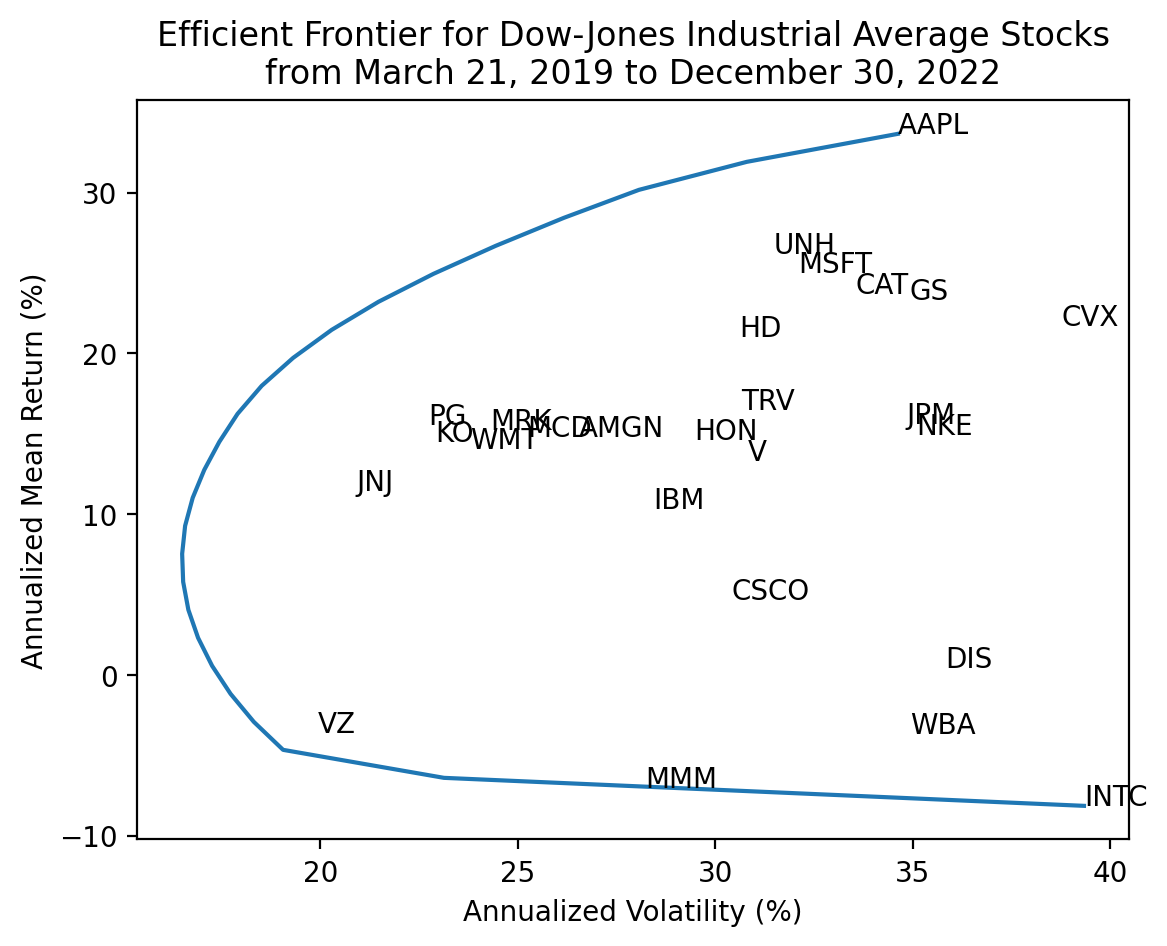

In [42]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(
    f'Efficient Frontier for Dow-Jones Industrial Average Stocks' +
    f'\nfrom {returns_2.index[0]:%B %d, %Y} to {returns_2.index[-1]:%B %d, %Y}'
)

for t, x, y in zip(
    returns_2.columns, 
    returns_2.std().mul(100*np.sqrt(252)),
    returns_2.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

### Find the maximum Sharpe Ratio portfolio with all available data for the current the DJIA stocks

In [43]:
res_sharpe_6 = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns_2.shape[1]) / returns_2.shape[1],
    args=(returns_2, 252, 0),
    bounds=[(0,1) for _ in range(returns_2.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # want eq constraint to = 0
    )
)

In [44]:
port_sharpe(x=res_sharpe_6['x'], r=returns_2, ppy=252, tgt=0)

1.092759027029442

### Compare the $\frac{1}{n}$ and maximum Sharpe Ratio portfolios with all available data for the current DJIA stocks

Use all but the last 252 trading days to estimate the maximum Sharpe Ratio portfolio weights.
Then use the last 252 trading days of data to compare the $\frac{1}{n}$  maximum Sharpe Ratio portfolios.

In [45]:
res_sharpe_x = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns_2.shape[1]) / returns_2.shape[1],
    args=(returns_2.iloc[:-252], 252, 0),
    bounds=[(0,1) for _ in range(returns_2.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # want eq constraint to = 0
    )
)

assert res_sharpe_x['success']
# res_sharpe_x

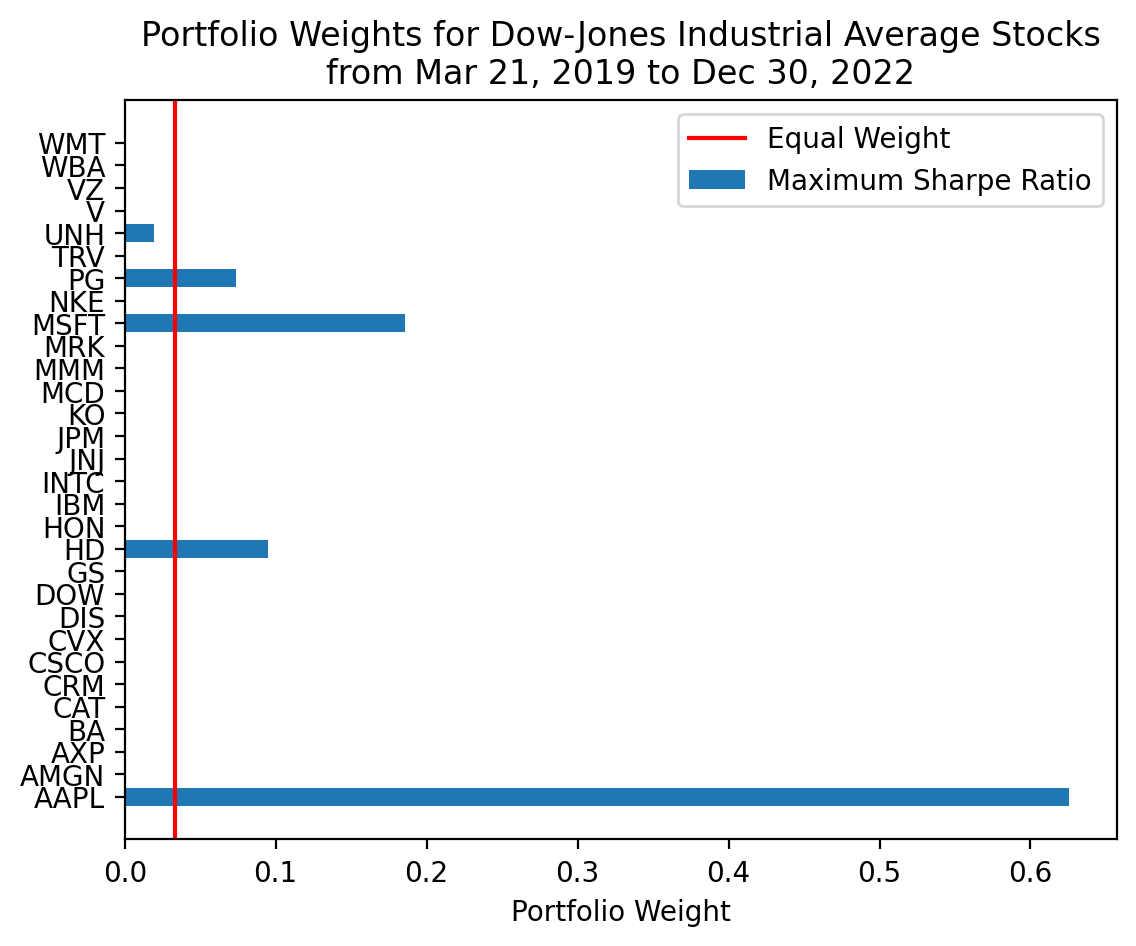

In [46]:
plt.barh(
    y=returns_2.columns,
    width=res_sharpe_x['x'],
    label='Maximum Sharpe Ratio'
)
plt.axvline(1/30, color='red', label='Equal Weight')
plt.legend()
plt.xlabel('Portfolio Weight')
plt.title(
    'Portfolio Weights for Dow-Jones Industrial Average Stocks' +
    f'\nfrom {returns_2.index[0]:%b %d, %Y} to {returns_2.index[-1]:%b %d, %Y}'
)
plt.show()

In [47]:
port_sharpe(x=res_sharpe_x['x'], r=returns_2.iloc[:-252], ppy=252, tgt=0)

1.63277447434889

In [48]:
port_sharpe(x=np.ones(returns_2.shape[1])/returns_2.shape[1], r=returns_2.iloc[:-252], ppy=252, tgt=0)

0.8019384916171576

Out of sample:

In [49]:
port_sharpe(x=res_sharpe_x['x'], r=returns_2.iloc[-252:], ppy=252, tgt=0)

-0.7218303076039226

In [50]:
port_sharpe(x=np.ones(returns_2.shape[1])/returns_2.shape[1], r=returns_2.iloc[-252:], ppy=252, tgt=0)

-0.2615614328449418

It is hard to beat the $\frac{1}{n}$ portfolio because mean returns (and covariances) are hard to predict!